##Wafer_data


| Situation     | Loss Change                          | Accuracy Change               | Explanation                                          |
|---------------|------------------------------------|------------------------------|------------------------------------------------------|
| Convergence   | Training and validation loss both gradually decrease | Metrics gradually increase   | Model is learning properly, progressively finding better solutions |
| Overfitting   | Training loss decreases, validation loss starts increasing | Training metrics keep improving, validation metrics decrease | Model starts memorizing training data, generalization ability drops |
| Divergence    | Loss keeps increasing or unstable   | Metrics unstable or decreasing | Learning rate too high or model unstable, training fails |
| Stagnation    | Loss and metrics stay unchanged or change very little |                              | Model learning stagnates, may need parameter or architecture adjustment |


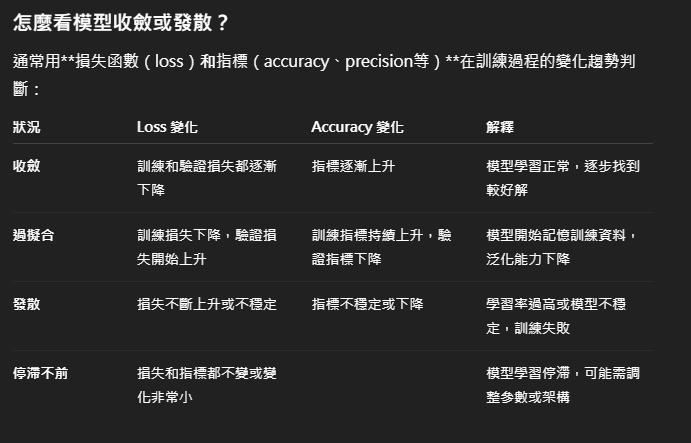

Model1(overfitting)

Macro Precision: 0.9915

Macro Recall:    0.9326

Macro F1-score:  0.9589

Subset Accuracy: 0.8897

Model2(Regularziztion=0.5)


Macro Precision: 0.9927

Macro Recall:    0.8027

Macro F1-score:  0.8516

Subset Accuracy: 0.6747



Model4 (Regularization 0.3 and early stop)

Macro Precision: 0.9934

Macro Recall:    0.8965

Macro F1-score:  0.9384

Subset Accuracy: 0.8348

Model5 (model4+學習速率)


Macro Precision: 0.8630

Macro Recall:    0.6915

Macro F1-score:  0.7615

Subset Accuracy: 0.3889

##解壓縮

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!unzip archive.zip -d /content/wafer_dataset
!ls /content/wafer_dataset

In [ ]:
import numpy as np
data = np.load('/content/wafer_dataset/Wafer_Map_Datasets.npz')  # 確保路徑正確
print(data.files)

##雲端

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
data = np.load('/content/drive/MyDrive/wafer_data/Wafer_Map_Datasets.npz')  # 確保路徑正確
print(data.files)



##套件


In [ ]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from tensorflow.keras import backend as K

K.clear_session()


seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

##資料顯示

In [ ]:
arr0 = data['arr_0']
arr1 = data['arr_1']

print(arr0.shape)
print(arr1.shape)

print(arr0[:5])
print(arr1[:5])

# arr_0 has 38,015 wafer images, each 52x52 pixels.
# arr_1 has 8 labels for each wafer image, showing defect types.

In [ ]:
# 1. 標籤分布統計
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


label_counts = arr1.sum(axis=0)  # 每個缺陷類別出現多少張圖
label_names = ['C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

plt.figure(figsize=(10,6))
sns.barplot(x=label_names, y=label_counts)
plt.title('Defect Label Distribution')
plt.ylabel('Number of Samples')
plt.show()


In [ ]:

# 2. 隨機抽5張圖看影像和對應標籤
def plot_samples(images, labels, label_names, n=5):
    plt.figure(figsize=(15,3))
    for i in range(n):
        idx = np.random.randint(0, images.shape[0])
        plt.subplot(1, n, i+1)
        plt.imshow(images[idx], cmap='gray')
        plt.title('Labels: ' + ','.join([label_names[j] for j,v in enumerate(labels[idx]) if v==1]))
        plt.axis('off')
    plt.show()

plot_samples(arr0, arr1, label_names)

## **Model 1  (Over fitting)**

##Macro Precision: 0.9915

##Macro Recall:    0.9326

##Macro F1-score:  0.9589

##Subset Accuracy: 0.8897


In [ ]:

# 1. 載入資料

X = data['arr_0']  # shape (38015, 52, 52)
y = data['arr_1']  # shape (38015, 8)

# 2. 前處理：CNN 要4D input (batch, height, width, channel)
X = X[..., np.newaxis]  # 變成 (38015, 52, 52, 1)

# 3. 分割訓練集和驗證集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

# 4. 建立簡單CNN模型
model_1 = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(52,52,1)),  ##卷基層 使用 32 個 3x3 的濾波器，在整張圖片上滑動，把圖片變成 32 張特徵圖（feature maps）
    layers.MaxPooling2D(2,2), #降維，讓圖片變小，但保留重要資訊，降低計算量，可不用
    layers.Conv2D(64, (3,3), activation='relu'),##利用池化層壓縮後再做一次卷基層
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(8, activation='sigmoid')  # 8個輸出，用 sigmoid 做多標籤分類
])

model_1.compile(optimizer='adam',
              loss='binary_crossentropy',  # 多標籤用binary crossentropy
              metrics=['accuracy'])

model_1.summary()

# 5. 訓練模型
history = model_1.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_val, y_val))


Epoch 1/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 130s 253ms/step - accuracy: 0.4073 - loss: 0.3669 - val_accuracy: 0.7482 - val_loss: 0.1535
Epoch 2/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 139s 247ms/step - accuracy: 0.6539 - loss: 0.1288 - val_accuracy: 0.6249 - val_loss: 0.0920
Epoch 3/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 142s 247ms/step - accuracy: 0.6349 - loss: 0.0710 - val_accuracy: 0.6483 - val_loss: 0.0567
Epoch 4/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 161s 286ms/step - accuracy: 0.6186 - loss: 0.0507 - val_accuracy: 0.6449 - val_loss: 0.0499
Epoch 5/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 129s 255ms/step - accuracy: 0.6015 - loss: 0.0400 - val_accuracy: 0.6235 - val_loss: 0.0460
Epoch 6/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 124s 247ms/step - accuracy: 0.5860 - loss: 0.0337 - val_accuracy: 0.5676 - val_loss: 0.0363
Epoch 7/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 142s 247ms/step - accuracy: 0.5709 - loss: 0.0290 - val_accuracy: 0.5422 - val_loss: 0.0375
Epoch 8/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 123s 244ms/step - accuracy: 0.5592 - loss: 0.0263 - val_accuracy: 0.5406 - val_loss: 0.0431
Epoch 9/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 123s 244ms/step - accuracy: 0.5481 - loss: 0.0234 - val_accuracy: 0.5471 - val_loss: 0.0490
Epoch 10/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 142s 244ms/step - accuracy: 0.5388 - loss: 0.0216 - val_accuracy: 0.5024 - val_loss: 0.0500


輸出大小 = (輸入大小 - 濾波器大小 + 2*padding) / stride + 1

padding:填充

Stride:步距(預設為1)

輸出大小 = (輸入大小 - 濾波器大小 + 2*padding) / stride + 1

padding:填充

Stride:步距(預設為1)

In [ ]:

plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

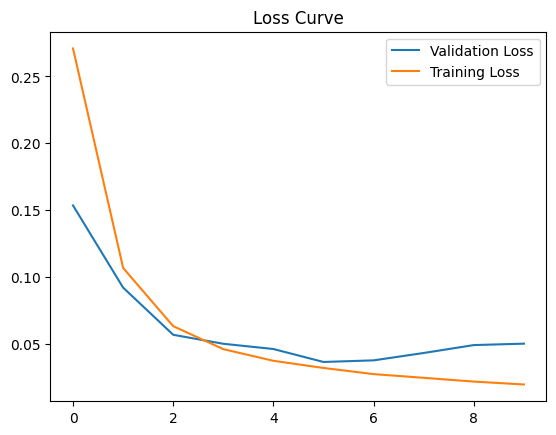

In [ ]:

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



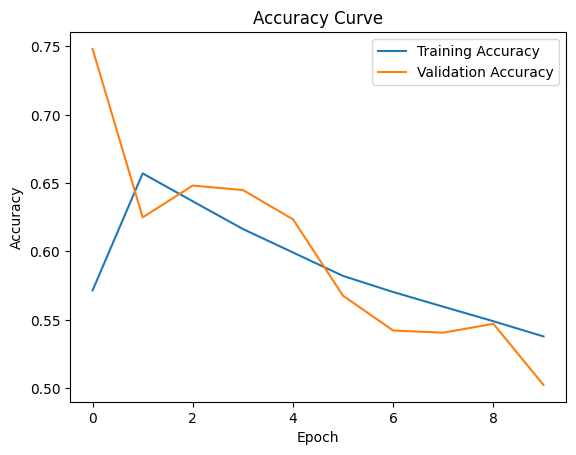


In [ ]:


y_pred_prob = model_1.predict(X_val)

# 設定閾值：你可以調整為 0.5, 0.7, 0.9, 0.95 看表現
threshold = 0.9
y_pred = (y_pred_prob >= threshold).astype(int)

# 評估指標（適用多標籤）
macro_precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
macro_f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
subset_acc = accuracy_score(y_val, y_pred)  # 完全正確的樣本比例

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")
print(f"Subset Accuracy: {subset_acc:.4f}")


Macro Precision: 0.9915

Macro Recall:    0.9326

Macro F1-score:  0.9589

Subset Accuracy: 0.8897

##Model2(Regularization = 0.5)

##Macro Precision: 0.9927

##Macro Recall:    0.8027

##Macro F1-score:  0.8516

##Subset Accuracy: 0.6747

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models


X = data['arr_0']
y = data['arr_1']

# CNN 輸入格式 (batch, height, width, channel)
X = X[..., np.newaxis]

# 切分資料
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

# 建立模型
model_2 = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(52,52,1)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # 加入 Dropout 做正則化
    layers.Dense(8, activation='sigmoid')
])

model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])  # training 仍可觀察 accuracy

history = model_2.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_val, y_val))


Epoch 1/10

505/505 ━━━━━━━━━━━━━━━━━━━━ 126s 246ms/step - accuracy: 0.3498 - loss: 0.4300 - val_accuracy: 0.7393 - val_loss: 0.1912

Epoch 2/10

505/505 ━━━━━━━━━━━━━━━━━━━━ 124s 246ms/step - accuracy: 0.6859 - loss: 0.2038 - val_accuracy: 0.7761 - val_loss: 0.0867
Epoch 3/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 141s 244ms/step - accuracy: 0.7042 - loss: 0.1509 - val_accuracy: 0.8059 - val_loss: 0.0692
Epoch 4/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 145s 251ms/step - accuracy: 0.7326 - loss: 0.1266 - val_accuracy: 0.8038 - val_loss: 0.0588
Epoch 5/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 142s 252ms/step - accuracy: 0.7236 - loss: 0.1124 - val_accuracy: 0.7985 - val_loss: 0.0616
Epoch 6/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 125s 247ms/step - accuracy: 0.7328 - loss: 0.1021 - val_accuracy: 0.8061 - val_loss: 0.0491
Epoch 7/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 132s 262ms/step - accuracy: 0.7271 - loss: 0.0935 - val_accuracy: 0.7941 - val_loss: 0.0429
Epoch 8/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 135s 247ms/step - accuracy: 0.7415 - loss: 0.0888 - val_accuracy: 0.7934 - val_loss: 0.0424
Epoch 9/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 140s 243ms/step - accuracy: 0.7414 - loss: 0.0830 - val_accuracy: 0.7941 - val_loss: 0.0400
Epoch 10/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 143s 246ms/step - accuracy: 0.7303 - loss: 0.0802 - val_accuracy: 0.7650 - val_loss: 0.0414

In [ ]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


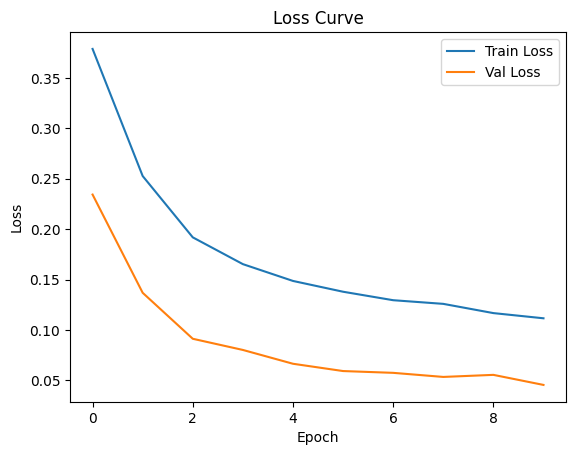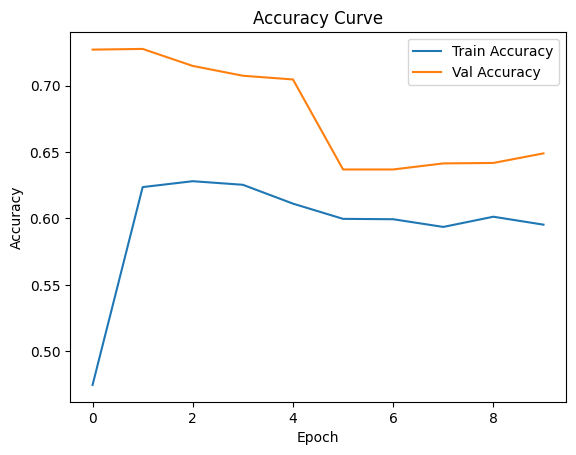

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_pred_prob = model_2.predict(X_val)

# 設定閾值：你可以調整為 0.5, 0.7, 0.9, 0.95 看表現
threshold = 0.9
y_pred = (y_pred_prob >= threshold).astype(int)

# 評估指標（適用多標籤）
macro_precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
macro_f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
subset_acc = accuracy_score(y_val, y_pred)  # 完全正確的樣本比例

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")
print(f"Subset Accuracy: {subset_acc:.4f}")



## Model 3 (VGG16 and aug)


##Macro Precision: 0.4962

##Macro Recall:    0.3029

##Macro F1-score:  0.3326

##Subset Accuracy: 0.0931

Pretrained Model


---
為什麼要用預訓練模型？
節省訓練時間
自己從頭訓練一個模型需要大量的資料和時間，預訓練模型已經有了「先驗知識」，直接用它可以快速達到不錯的效果。

降低資料需求
預訓練模型因為已經學過大量圖片的特徵，使用在自己資料時可以不用那麼多訓練資料。

提升效能
很多時候用預訓練模型微調（fine-tuning）後，模型的準確率會比完全從頭訓練還高。


In [ ]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# 讀取資料
data = np.load('/content/wafer_dataset/Wafer_Map_Datasets.npz')
X = data['arr_0']  # (38015, 52, 52)
y = data['arr_1']  # (38015, 8)

# 擴充通道：黑白圖轉RGB
X = np.repeat(X[..., np.newaxis], 3, axis=-1)  # (38015, 52, 52, 3)

# 切分資料
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

# 建立自定義資料產生器
class ResizeDataGenerator(Sequence):
    def __init__(self, X, y, batch_size=32, is_train=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.is_train = is_train

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))
    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_x_resized = tf.image.resize(tf.cast(batch_x, tf.float32), (224, 224)).numpy()
        batch_x_preprocessed = preprocess_input(batch_x_resized)
        return batch_x_preprocessed, batch_y

train_gen = ResizeDataGenerator(X_train, y_train, batch_size=32, is_train=True)
val_gen = ResizeDataGenerator(X_val, y_val, batch_size=32, is_train=False)

# 模型架構
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='sigmoid')  # 多標籤輸出
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 開始訓練
history = model.fit(train_gen, epochs=10, validation_data=val_gen, callbacks=[early_stop])


In [ ]:
import matplotlib.pyplot as plt

# 繪製 Loss 與 Accuracy 曲線
plt.figure(figsize=(12, 5))

# Loss 曲線
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)

# Accuracy 曲線
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
# 取得預測結果
y_pred_prob = model.predict(val_gen)
threshold = 0.9
y_pred = (y_pred_prob >= threshold).astype(int)

# 計算指標
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

macro_precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
macro_f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
subset_acc = accuracy_score(y_val, y_pred)

print(f"\n📊 Evaluation Results (Threshold = {threshold}):")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")
print(f"Subset Accuracy: {subset_acc:.4f}")


##Model 4 (Regularization 0.5 and early stop)

##Macro Precision: 0.8620

##Macro Recall:    0.6739

##Macro F1-score:  0.7487

##Subset Accuracy: 0.3775

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# 提早停止：如果 val_loss 3 個 epoch 都沒有改善，就停止訓練
early_stop = EarlyStopping(
    monitor='val_loss',       # 監控驗證集損失
    patience=3,               # 容忍 3 個 epoch 無改善
    restore_best_weights=True  # 還原到最佳權重
)
data = np.load('/content/wafer_dataset/Wafer_Map_Datasets.npz')
X = data['arr_0']
y = data['arr_1']

# CNN 輸入格式 (batch, height, width, channel)
X = X[..., np.newaxis]

# 切分資料
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

# 建立模型
model_4 = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(52,52,1)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # 加入 Dropout 做正則化
    layers.Dense(8, activation='sigmoid')
])

model_4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])  # training 仍可觀察 accuracy

history = model_4.fit(X_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop] )



In [ ]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras import backend as K
K.clear_session()
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_pred_prob = model_4.predict(X_val)

# 設定閾值：你可以調整為 0.5, 0.7, 0.9, 0.95 看表現
threshold = 0.9
y_pred = (y_pred_prob >= threshold).astype(int)

# 評估指標（適用多標籤）
macro_precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
macro_f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
subset_acc = accuracy_score(y_val, y_pred)  # 完全正確的樣本比例

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")
print(f"Subset Accuracy: {subset_acc:.4f}")


## Model5(Model4+學習速率)

##Macro Precision: 0.8620

##Macro Recall:    0.6739

##Macro F1-score:  0.7487

##Subset Accuracy: 0.3775

In [ ]:
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LambdaCallback

# --- set seed 42---
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# --- 載入資料 ---
data = np.load('/content/wafer_dataset/Wafer_Map_Datasets.npz')
X = data['arr_0']  # shape: (N, 52, 52)
y = data['arr_1']  # shape: (N, 8) 多標籤

# CNN 輸入格式 (N, 52, 52, 1)
X = X[..., np.newaxis]

# --- 切分訓練與驗證集 ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=SEED
)

# --- 建立模型 ---
model_5 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(52, 52, 1)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='sigmoid')  # 多標籤任務
])

# --- Optimizer：學習率設定為 1e-4 ---
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model_5.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- EarlyStopping ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# --- ReduceLROnPlateau ---
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# --- 每個 epoch 印出學習率 ---
def lr_printer(epoch, logs):
    lr = float(tf.keras.backend.get_value(model_5.optimizer.learning_rate))
    print(f"Epoch {epoch + 1}: learning rate = {lr:.6f}")

lr_print_callback = LambdaCallback(on_epoch_end=lr_printer)

# --- 訓練模型 ---
history = model_5.fit(
    X_train, y_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, lr_scheduler, lr_print_callback]
)


In [ ]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_pred_prob = model_5.predict(X_val)

# 設定閾值：你可以調整為 0.5, 0.7, 0.9, 0.95 看表現
threshold = 0.9
y_pred = (y_pred_prob >= threshold).astype(int)

# 評估指標（適用多標籤）
macro_precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
macro_f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
subset_acc = accuracy_score(y_val, y_pred)  # 完全正確的樣本比例

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")
print(f"Subset Accuracy: {subset_acc:.4f}")

## model6 (Model 4加 BatchNormalization + LeakyReLU +learning rate 1e-3）

##Macro Precision: 0.9984

##Macro Recall:    0.9427

##Macro F1-score:  0.9667

##Subset Accuracy: 0.9490

In [ ]:
# --- 基本套件 ---
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras.layers import BatchNormalization, LeakyReLU

# --- 設定隨機種子 ---
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# --- 載入資料 ---
data = np.load('/content/wafer_dataset/Wafer_Map_Datasets.npz')
X = data['arr_0']  # (N, 52, 52)
y = data['arr_1']  # (N, 8)

X = X[..., np.newaxis]  # CNN 格式

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=SEED
)

# --- 升級版模型 ---
model_4_upgraded = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', input_shape=(52, 52, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    layers.Dropout(0.5),

    layers.Dense(8, activation='sigmoid')
])

model_4_upgraded.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- Callback ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

def lr_printer(epoch, logs):
    lr = float(tf.keras.backend.get_value(model_4_upgraded.optimizer.learning_rate))
    print(f"Epoch {epoch + 1}: learning rate = {lr:.6f}")

lr_print_callback = LambdaCallback(on_epoch_end=lr_printer)

# --- 模型訓練 ---
history = model_4_upgraded.fit(
    X_train, y_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, lr_scheduler, lr_print_callback]
)

# --- 模型預測 ---
y_pred_prob = model_4_upgraded.predict(X_val)
threshold = 0.9
y_pred = (y_pred_prob >= threshold).astype(int)

# --- 指標評估 ---
macro_precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
macro_f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
subset_acc = accuracy_score(y_val, y_pred)

print(f"\n📊 評估結果（Threshold = {threshold}）")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")
print(f"Subset Accuracy: {subset_acc:.4f}")

# --- 畫圖：Loss 與 Accuracy 曲線 ---
plt.figure(figsize=(12, 5))

# Loss 圖
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.grid(True)
plt.legend()

# Accuracy 圖
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## model7  (model6基礎+學習速率調成1e-4+batchsize縮小成64)



##Macro Precision: 0.9974

##Macro Recall:    0.9328

##Macro F1-score:  0.9597

##Subset Accuracy: 0.9430

In [ ]:
# --- 基本套件 ---
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras.layers import BatchNormalization, LeakyReLU

# --- 設定隨機種子 ---
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# --- 載入資料 ---
data = np.load('/content/wafer_dataset/Wafer_Map_Datasets.npz')
X = data['arr_0']  # (N, 52, 52)
y = data['arr_1']  # (N, 8)

X = X[..., np.newaxis]  # CNN 格式

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=SEED
)

# --- 升級版模型 ---
model_4_upgraded = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', input_shape=(52, 52, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    layers.Dropout(0.5),

    layers.Dense(8, activation='sigmoid')
])

model_4_upgraded.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- Callback ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

def lr_printer(epoch, logs):
    lr = float(tf.keras.backend.get_value(model_4_upgraded.optimizer.learning_rate))
    print(f"Epoch {epoch + 1}: learning rate = {lr:.6f}")

lr_print_callback = LambdaCallback(on_epoch_end=lr_printer)

# --- 模型訓練 ---
history = model_4_upgraded.fit(
    X_train, y_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, lr_scheduler, lr_print_callback]
)

# --- 模型預測 ---
y_pred_prob = model_4_upgraded.predict(X_val)
threshold = 0.9
y_pred = (y_pred_prob >= threshold).astype(int)

# --- 指標評估 ---
macro_precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
macro_f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
subset_acc = accuracy_score(y_val, y_pred)

print(f"\n📊 評估結果（Threshold = {threshold}）")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")
print(f"Subset Accuracy: {subset_acc:.4f}")

# --- 畫圖：Loss 與 Accuracy 曲線 ---
plt.figure(figsize=(12, 5))

# Loss 圖
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.grid(True)
plt.legend()

# Accuracy 圖
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


##Model8 = Model7+ (64 → 128 → 256 + L2 regularizer)

##📊 評估結果（Threshold = 0.9）

##Macro Precision: 0.9969

##Macro Recall:    0.9548

##Macro F1-score:  0.9741

##Subset Accuracy: 0.9402

In [ ]:
# --- 基本套件 ---
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras.layers import BatchNormalization, LeakyReLU

# --- 設定隨機種子 ---
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# --- 載入資料 ---
data = np.load('/content/wafer_dataset/Wafer_Map_Datasets.npz')
X = data['arr_0']  # (N, 52, 52)
y = data['arr_1']  # (N, 8)

X = X[..., np.newaxis]  # CNN 格式

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=SEED
)

# --- 升級版模型 ---
model_8 = models.Sequential([
    layers.Conv2D(64, (3, 3), padding='same', input_shape=(52, 52, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    layers.Dropout(0.5),

    layers.Dense(8, activation='sigmoid')
])

model_8.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- Callback ---
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

def lr_printer(epoch, logs):
    lr = float(tf.keras.backend.get_value(model_8.optimizer.learning_rate))
    print(f"Epoch {epoch + 1}: learning rate = {lr:.6f}")

lr_print_callback = LambdaCallback(on_epoch_end=lr_printer)

# --- 模型訓練 ---
history = model_8.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, lr_scheduler, lr_print_callback]
)

# --- 模型預測 ---
y_pred_prob = model_8.predict(X_val)
threshold = 0.9
y_pred = (y_pred_prob >= threshold).astype(int)

# --- 指標評估 ---
macro_precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
macro_f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
subset_acc = accuracy_score(y_val, y_pred)

# --- 畫圖：Loss 與 Accuracy 曲線 ---
plt.figure(figsize=(12, 5))

# Loss 圖
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.grid(True)
plt.legend()

# Accuracy 圖
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

print(f"\n📊 評估結果（Threshold = {threshold}）")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")
print(f"Subset Accuracy: {subset_acc:.4f}")


## model9 (多個 CNN 架構 + 融合)

##Macro Precision: 0.9990

##Macro Recall:    0.9531

##Macro F1-score:  0.9743

##Subset Accuracy: 0.9379


In [ ]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- 設定隨機種子 ---
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# --- 載入資料 ---
data = np.load('/content/wafer_dataset/Wafer_Map_Datasets.npz')
X = data['arr_0']
y = data['arr_1']
X = X[..., np.newaxis]  # (N, 52, 52, 1)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=SEED
)

# --- 模型變體定義 ---
def create_model_9_variant1():
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), padding='same', input_shape=(52, 52, 1)),
        layers.BatchNormalization(), layers.LeakyReLU(alpha=0.1), layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(), layers.LeakyReLU(alpha=0.1), layers.MaxPooling2D(2, 2),
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(), layers.LeakyReLU(alpha=0.1), layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(), layers.LeakyReLU(alpha=0.1), layers.Dropout(0.5),
        layers.Dense(8, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_model_9_variant2():
    model = models.Sequential([
        layers.Conv2D(48, (3, 3), padding='same', input_shape=(52, 52, 1)),
        layers.BatchNormalization(), layers.LeakyReLU(alpha=0.1), layers.MaxPooling2D(2, 2),
        layers.Conv2D(96, (3, 3), padding='same'),
        layers.BatchNormalization(), layers.LeakyReLU(alpha=0.1), layers.MaxPooling2D(2, 2),
        layers.Conv2D(192, (3, 3), padding='same'),
        layers.BatchNormalization(), layers.LeakyReLU(alpha=0.1), layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(), layers.LeakyReLU(alpha=0.1), layers.Dropout(0.4),
        layers.Dense(8, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_model_9_variant3():
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), padding='same', input_shape=(52, 52, 1)),
        layers.BatchNormalization(), layers.LeakyReLU(alpha=0.1), layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(), layers.LeakyReLU(alpha=0.1), layers.MaxPooling2D(2, 2),
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(), layers.LeakyReLU(alpha=0.1), layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(), layers.LeakyReLU(alpha=0.1), layers.Dropout(0.5),
        layers.Dense(8, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- 模型訓練 ---
models_list = [
    create_model_9_variant1(),
    create_model_9_variant2(),
    create_model_9_variant3()
]

histories = []
for i, model in enumerate(models_list):
    print(f"Training model_9 variant {i+1}...")
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=128,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, lr_scheduler]
    )
    histories.append(history)

# --- 預測與融合 ---
preds = [model.predict(X_val) for model in models_list]
avg_pred_prob = np.mean(preds, axis=0)

threshold = 0.9
y_pred_ensemble = (avg_pred_prob >= threshold).astype(int)

# --- 評估指標 ---
macro_precision = precision_score(y_val, y_pred_ensemble, average='macro', zero_division=0)
macro_recall = recall_score(y_val, y_pred_ensemble, average='macro', zero_division=0)
macro_f1 = f1_score(y_val, y_pred_ensemble, average='macro', zero_division=0)
subset_acc = accuracy_score(y_val, y_pred_ensemble)

print(f"\n📊 model_9 Ensemble 評估結果（Threshold = {threshold}）")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")
print(f"Subset Accuracy: {subset_acc:.4f}")

# --- 畫圖：Loss 與 Accuracy 曲線 ---
plt.figure(figsize=(14, 6))

# Loss 曲線
plt.subplot(1, 2, 1)
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Model 9 Variant {i+1} - Train Loss')
    plt.plot(history.history['val_loss'], label=f'Model 9 Variant {i+1} - Val Loss', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy 曲線
plt.subplot(1, 2, 2)
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'Model 9 Variant {i+1} - Train Acc')
    plt.plot(history.history['val_accuracy'], label=f'Model 9 Variant {i+1} - Val Acc', linestyle='--')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## model10 (CNN + MLP 混合模型)

##Macro Precision: 0.9975

##Macro Recall:    0.9716

##Macro F1-score:  0.9841

##Subset Accuracy: 0.9523

In [ ]:
# --- 基本套件 ---
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Concatenate

# --- 設定隨機種子 ---
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# --- 載入資料 ---
data = np.load('/content/wafer_dataset/Wafer_Map_Datasets.npz')
X = data['arr_0']  # (N, 52, 52)
y = data['arr_1']  # (N, 8)
X = X[..., np.newaxis]  # CNN 格式

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=SEED
)

# --- 建立 model_10（CNN + MLP 分支）---
input_layer = Input(shape=(52, 52, 1))

# CNN 分支
cnn = layers.Conv2D(64, (3, 3), padding='same')(input_layer)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.1)(cnn)
cnn = layers.MaxPooling2D(2, 2)(cnn)

cnn = layers.Conv2D(128, (3, 3), padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.1)(cnn)
cnn = layers.MaxPooling2D(2, 2)(cnn)

cnn = layers.Conv2D(256, (3, 3), padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.1)(cnn)
cnn = layers.MaxPooling2D(2, 2)(cnn)

cnn = layers.Flatten()(cnn)
cnn = layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(cnn)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.1)(cnn)
cnn = layers.Dropout(0.5)(cnn)

# MLP 分支
mlp = layers.Flatten()(input_layer)
mlp = layers.Dense(512)(mlp)
mlp = LeakyReLU(alpha=0.1)(mlp)
mlp = layers.Dense(256)(mlp)
mlp = LeakyReLU(alpha=0.1)(mlp)

# 特徵融合
merged = Concatenate()([cnn, mlp])
merged = layers.Dense(256)(merged)
merged = LeakyReLU(alpha=0.1)(merged)
merged = layers.Dropout(0.5)(merged)
output = layers.Dense(8, activation='sigmoid')(merged)

# 建立模型
model_10 = Model(inputs=input_layer, outputs=output)

model_10.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- Callback 設定 ---
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# --- 模型訓練 ---
history = model_10.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, lr_scheduler]
)

# --- 模型預測 ---
y_pred_prob = model_10.predict(X_val)
threshold = 0.9
y_pred = (y_pred_prob >= threshold).astype(int)

# --- 評估指標 ---
macro_precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
macro_f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
subset_acc = accuracy_score(y_val, y_pred)

print(f"\n📊 model_10 評估結果（Threshold = {threshold}）")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")
print(f"Subset Accuracy: {subset_acc:.4f}")

# --- 畫圖：Loss 與 Accuracy 曲線 ---
plt.figure(figsize=(12, 5))

# Loss 圖
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.grid(True)
plt.legend()

# Accuracy 圖
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


##model11 (CNN+MLP+資料增強)

##Macro Precision: 0.9970

##Macro Recall:    0.9646

##Macro F1-score:  0.9792

##Subset Accuracy: 0.9721

In [ ]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 設定隨機種子
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# 載入資料
data = np.load('/content/wafer_dataset/Wafer_Map_Datasets.npz')
X = data['arr_0']  # (N, 52, 52)
y = data['arr_1']  # (N, 8)
X = X[..., np.newaxis]  # 灰階單通道

# 切分資料
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=SEED)

# 資料增強器（灰階圖片可用）

train_datagen = ImageDataGenerator(
    rotation_range=10,          # 小角度旋轉，避免太大變形
    width_shift_range=0.05,     # 小幅水平平移
    height_shift_range=0.05,    # 小幅垂直平移
    horizontal_flip=True,       # 水平翻轉通常對晶圓圖可接受
    zoom_range=0.05             # 小幅縮放
    # vertical_flip=False       # 不做垂直翻轉，避免影響缺陷方向
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=128, seed=SEED)
val_generator = val_datagen.flow(X_val, y_val, batch_size=128, seed=SEED)
input_layer = Input(shape=(52, 52, 1))

# CNN 分支
cnn = layers.Conv2D(64, (3, 3), padding='same')(input_layer)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.1)(cnn)
cnn = layers.MaxPooling2D(2, 2)(cnn)

cnn = layers.Conv2D(128, (3, 3), padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.1)(cnn)
cnn = layers.MaxPooling2D(2, 2)(cnn)

cnn = layers.Conv2D(256, (3, 3), padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.1)(cnn)
cnn = layers.MaxPooling2D(2, 2)(cnn)

cnn = layers.Flatten()(cnn)
cnn = layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(cnn)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.1)(cnn)
cnn = layers.Dropout(0.5)(cnn)

# MLP 分支
mlp = layers.Flatten()(input_layer)
mlp = layers.Dense(512)(mlp)
mlp = LeakyReLU(alpha=0.1)(mlp)
mlp = layers.Dense(256)(mlp)
mlp = LeakyReLU(alpha=0.1)(mlp)

# 特徵融合
merged = Concatenate()([cnn, mlp])
merged = layers.Dense(256)(merged)
merged = LeakyReLU(alpha=0.1)(merged)
merged = layers.Dropout(0.5)(merged)
output = layers.Dense(8, activation='sigmoid')(merged)

model_11 = Model(inputs=input_layer, outputs=output)

model_11.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callback 設定
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# 訓練 model_11（資料增強）
history_11 = model_11.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, lr_scheduler]
)

# 預測與評估
y_pred_prob = model_11.predict(X_val)
threshold = 0.9
y_pred = (y_pred_prob >= threshold).astype(int)

macro_precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
macro_f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
subset_acc = accuracy_score(y_val, y_pred)

print(f"\n📊 model_11 評估結果（Threshold = {threshold}）")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")
print(f"Subset Accuracy: {subset_acc:.4f}")

# 畫 Loss 與 Accuracy 曲線
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_11.history['loss'], label='Train Loss', marker='o')
plt.plot(history_11.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_11.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_11.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


##modeltest(model11 標準化版本)


##Macro Precision: 0.9965

##Macro Recall:    0.9755

##Macro F1-score:  0.9856

##Subset Accuracy: 0.9632

In [ ]:

import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- 設定隨機種子 ---
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# --- 載入資料並歸一化 ---
data = np.load('/content/wafer_dataset/Wafer_Map_Datasets.npz')
X = data['arr_0'].astype('float32')  # 轉 float32
X = X[..., np.newaxis]               # 灰階單通道
y = data['arr_1']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=SEED)

# --- 建立 ImageDataGenerator ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    zoom_range=0.05
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=128, seed=SEED, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=128, seed=SEED, shuffle=False)

# --- 建立 model_test 架構 ---
input_layer = Input(shape=(52, 52, 1))

cnn = layers.Conv2D(64, (3,3), padding='same')(input_layer)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.1)(cnn)
cnn = layers.MaxPooling2D(2,2)(cnn)

cnn = layers.Conv2D(128, (3,3), padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.1)(cnn)
cnn = layers.MaxPooling2D(2,2)(cnn)

cnn = layers.Conv2D(256, (3,3), padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.1)(cnn)
cnn = layers.MaxPooling2D(2,2)(cnn)

cnn = layers.Flatten()(cnn)
cnn = layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(cnn)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.1)(cnn)
cnn = layers.Dropout(0.5)(cnn)

mlp = layers.Flatten()(input_layer)
mlp = layers.Dense(512)(mlp)
mlp = LeakyReLU(alpha=0.1)(mlp)
mlp = layers.Dense(256)(mlp)
mlp = LeakyReLU(alpha=0.1)(mlp)

merged = Concatenate()([cnn, mlp])
merged = layers.Dense(256)(merged)
merged = LeakyReLU(alpha=0.1)(merged)
merged = layers.Dropout(0.5)(merged)
output = layers.Dense(8, activation='sigmoid')(merged)

model_test = Model(inputs=input_layer, outputs=output)

model_test.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- Callback ---
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_model_test.h5', monitor='val_loss', save_best_only=True)

# --- 訓練 ---
history = model_test.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)

# --- 預測與評估 ---
y_pred_prob = model_test.predict(X_val / 255.0)
threshold = 0.9
y_pred = (y_pred_prob >= threshold).astype(int)

macro_precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
macro_f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
subset_acc = accuracy_score(y_val, y_pred)

print(f"\n📊 model_test 評估結果（Threshold = {threshold}）")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")
print(f"Subset Accuracy: {subset_acc:.4f}")

# --- 畫 Loss 與 Accuracy 曲線 ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

##混和模型


In [ ]:
# model_10 和 model_11 已訓練完成

# 對驗證集做預測 (輸出機率)
y_pred_prob_10 = model_10.predict(X_val)
y_pred_prob_11 = model_11.predict(X_val)

# 預測結果取平均 (soft voting)
y_pred_prob_ensemble = (y_pred_prob_10 + y_pred_prob_11) / 2

# 設定閾值
threshold = 0.9
y_pred_ensemble = (y_pred_prob_ensemble >= threshold).astype(int)

# 計算評估指標
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

macro_precision = precision_score(y_val, y_pred_ensemble, average='macro', zero_division=0)
macro_recall = recall_score(y_val, y_pred_ensemble, average='macro', zero_division=0)
macro_f1 = f1_score(y_val, y_pred_ensemble, average='macro', zero_division=0)
subset_acc = accuracy_score(y_val, y_pred_ensemble)

print(f"\n📊 集成模型評估結果（Threshold = {threshold}）")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")
print(f"Subset Accuracy: {subset_acc:.4f}")


In [ ]:
model_11.save("model_11_best.h5")


##requirements

pandas
numpy
scikit-learn
tensorflow # 推測您使用了 TensorFlow/Keras
keras # 如果您是獨立安裝 Keras 而非透過 TensorFlow
matplotlib
seaborn

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 讀取資料與模型
data = np.load('/content/wafer_dataset/Wafer_Map_Datasets.npz')
X = data['arr_0']
y = data['arr_1']

# 切分資料集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# 載入模型
model = load_model('/content/model_11_best.h5')

# 預測
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.9).astype(int)

# 缺陷類型名稱
labels = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch']

# 每一類畫混淆矩陣
for i, label in enumerate(labels):
    cm = confusion_matrix(y_test[:, i], y_pred[:, i])

    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {label}')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{label}.png')
    plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import os
os.makedirs('/content/assets', exist_ok=True)

# 讀資料
data = np.load('/content/wafer_dataset/Wafer_Map_Datasets.npz')
X = data['arr_0']
y = data['arr_1']

# 分割資料集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# 載入模型
model = load_model('/content/model_11_best.h5')

# 模型預測
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.9).astype(int)

# 缺陷標籤
labels = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch']
# 建立圖片儲存資料夾
os.makedirs('assets', exist_ok=True)

def visualize_prediction(index, X, y_true, y_pred, labels):
    plt.figure(figsize=(3, 3))

    # 判斷是否有通道維度
    if X[index].ndim == 3:
        plt.imshow(X[index][:,:,0], cmap='gray')
    else:
        plt.imshow(X[index], cmap='gray')

    plt.axis('off')

    # 標籤轉文字
    true_labels = [labels[i] for i, val in enumerate(y_true[index]) if val == 1]
    pred_labels = [labels[i] for i, val in enumerate(y_pred[index]) if val == 1]

    # 圖片儲存
    fname = f'sample_{index}.png'
    save_path = os.path.join('assets', fname)
    plt.title(f'True: {", ".join(true_labels)}\nPred: {", ".join(pred_labels)}', fontsize=8)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

    return fname, true_labels, pred_labels
# 選幾張有趣的樣本畫圖（這裡挑 5 張）
example_indices = [0, 5, 10, 20, 25]

print("| Wafer Map | Ground Truth | Model Prediction |")
print("|-----------|--------------|------------------|")

for i in example_indices:
    fname, true_lbls, pred_lbls = visualize_prediction(i, X_test, y_test, y_pred, labels)
    print(f"| ![](assets/{fname}) | `{', '.join(true_lbls)}` | `{', '.join(pred_lbls)}` |")
